## 다소 생소할 수 있는 einops 패키지를 소개하겠습니다

einops는 직관적으로 tensor 의 차원을 변경할 수 있는 package 입니다.

주로, `rearrage` 와 `reduce`, `repeat` 을 사용합니다.

많은 설명보다, 사용 예시를 보죠! 

본 예시는 einops 의 공식 docs 를 참고했습니다.

----

## 패키지 및 이미지 준비

In [1]:
import numpy
from utils import display_np_arrays_as_images
import einops
from einops import rearrange, reduce, repeat
from matplotlib import pyplot as plt

display_np_arrays_as_images()

In [2]:
ims = numpy.load('./resources/test_images.npy', allow_pickle=False)
# There are 6 images of shape 96x96 with 3 color channels packed into tensor
print(ims.shape, ims.dtype)

(6, 96, 96, 3) float64


위 shape 을 보시면, 6장의 $ 96 \times 96 $ 크기의 RGB image 임을 확인할 수 있습니다.

각각을 시각화 해 보죠.

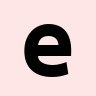

In [3]:
ims[0]

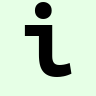

In [4]:
ims[1]

-----

## rearrange()

이제, 위의 $ 6 \times 96 \times 96 \times 3 $ 의 tensor를 변형해 봅시다!

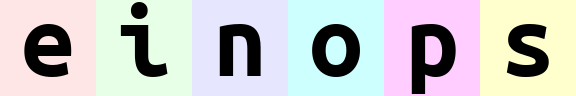

In [5]:
m_example1 = einops.rearrange(ims, 'b h w c -> h (b w) c')
m_example1

In [6]:
print('example_tensor shape: {}'.format(ims.shape))
print('output_tensor shape: {}'.format(m_example1.shape))

example_tensor shape: (6, 96, 96, 3)
output_tensor shape: (96, 576, 3)


위 예시를 보면, ims 의 shape 을 다음과 같이 설정하였습니다.
$$
 Batch \times hight \times width \times channel \\
 6 \times 96 \times 96 \times 3 
$$

그리고, 코드를 보시면 다음과 같이 shape 을 mapping 해 주게 됩니다. 
```python
einops.rearrange(ims, 'b h w c -> h (b w) c')
```
여기서 작성한 
```python
'b h w c -> h (b w) c'
 ```
 쿼리는 임의로 shape 에 대한 변수를 설정하고, 해당 변수에 맞춰서 tensor 의 shape 을 `->` 이후의 형태로 변형하라는 의미 입니다.

 또한, `()` 안에 임의로 정의한 변수를 같이 적게 되면, 자동으로 서로 곱한 형태로 변형해 줍니다.

 여기서, einpos 의 놀라운 점은, `h` 로 보여지는 hight 의 차원과 크기를 유지한 채,

  batch 와 width 의 차원을 융합 시켰고, 
  
  각 차원의 위치를 바꾸는 연산을 한번에 할 수 있다는 거죠!

 결론적으로 출력으로 얻어진 tensor 의 차원은
 $$
hight \times (batch * width) \times channel
 $$
이 되는 것을 알 수 있습니다. (width 의 길이가 이미지의 개수만큼 길어진 거죠)

그럼 다음 예제를 보죠.

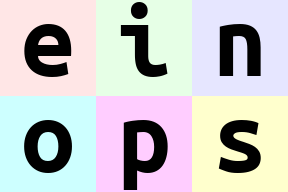

In [7]:
rearrange(ims, '(b1 b2) h w c -> (b1 h) (b2 w) c ', b1=2)

위 예시의 경우, `b1, b2` 라는 변수를 임의로 설정해서, 이미지를 변형한 모습입니다. 

`b2` 의 경우 `b1` 이 주어지면 자연스럽게 알 수 있기 때문에 굳이 넣어줄 필요가 없습니다. 

----

## reduce()

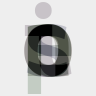

In [8]:
reduce(ims, 'b h w c -> h w c', 'mean')

위 예시의 경우, `reduce()` 에 대한 사용 예시입니다. 

말 그대로 reduce, 차원을 줄이는 것이며, 방법을 mean 으로 설정항여 위와 같은 모습으로 나타납니다. 

평균값을 사용하여 전체 이미지가 같이 보이게 되는거죠.

```
b h w c -> h w c
```
라는 표현에서, 총 이미지의 개수인 batch 에 대한 차원을 mean 으로 줄인것을 확인할 수 있습니다.

## repeat()

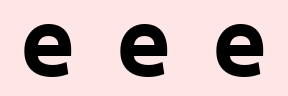

In [9]:
repeat(ims[0], 'h w c -> h (repeat w) c', repeat=3)

마지막으로, `repeat()` 의 경우, 동일한 값을 복사해서 차원을 변경할 수 있습니다. 

위 예시를 보면, `repeat=3` 으로 설정하고, `'h w c -> h (repeat w) c'` 처럼 표현해서 특정 차원을 반복할 수 있습니다.


-----

## einops for vit

ims[0] shape: (96, 96, 3)


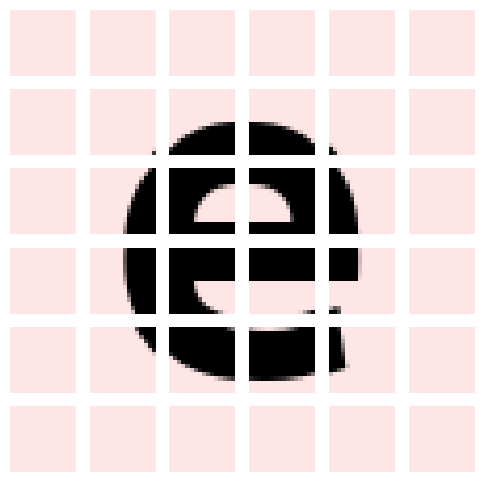

In [10]:
print('ims[0] shape:' ,ims[0].shape)
patchs  = rearrange(ims[0], '(h s1) (w s2) c -> (h w) s1 s2 c',  s1 = 16, s2 = 16)

plt.figure(figsize = (6,6))

for index in range(patchs.shape[0]):

    plt.subplot(6, 6, index+1)
    plt.imshow(patchs[index])   # patch size = (B=1, 36, 16, 16,3 ) 
    plt.axis('off')

plt.show()

이제, 실제로 ViT 를 위한 연산의 예시를 고려해 봅시다.

ViT 는 patch 라는 단위로, 이미지를 잘게 자릅니다. 이 과정을 위의 쿼리로 확인해 보죠!

> ```python
> ims[0] shape: (96, 96, 3)
> patchs  = rearrange(ims[0], '(h s1) (w s2) c -> (h w) s1 s2 c',  s1 = 16, s2 = 16)
> ```


`ims[0]` 의 shape 이 `96, 96, 3` 일 때, 이를 `(h s1) (w s2) c` 로 표현합니다. (s1, s2 == 16)
그럼, 
```python
96 == h * 16,
96 == w * 16,
```
이라는 표현이 되므로, 한 이미지를, $16 \times 16$ 의 크기로 나눈 위와 같은 모습으로 나타나게 되는 거죠.

`->` 이후에 `(h w) s1 s2 c`로 표현하여 $16 \times 16$ 으로 나누어진 패치의 개수를 batch 로 놓고, $16 \times 16 \times 3$ 이미지를 batch 개수 만큼 가지고 있는 것 처럼 나타낼 수 있습니다.

----

지금까지 확인한 내용만으로도 앞으로 나올 코드는 쉽게 이해할 수 있을겁니다!

> einops 에 대한 더 많은 정보는 공식 문서의 [`tutorial 문서`](https://einops.rocks/1-einops-basics/) 를 참고하시면 좋을 것 같습니다. 
